In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import numpy as np

from utils import remove_outliers

In [2]:
sns.set_theme(style="whitegrid")
sns.set_context('paper')

pd.set_option('display.max_rows', 10)

In [3]:
def calculate_increase(df1, df2, column):
    new_dataframe = []

    for flag in flags:
        for prog in progs:
            base_mean = df1[(df1['flag'] == flag) & (df1['program'] == prog)][column].mean()
            diff_mean = df2[(df2['flag'] == flag) & (df2['program'] == prog)][column].mean()
            
            increase = ((diff_mean - base_mean) / base_mean) * 100
            
            new_dataframe.append([prog, flag, base_mean, diff_mean, increase])

    return pd.DataFrame(new_dataframe, columns=['program', 'flag', 'base_mean', 'diff_mean', 'increase'])

In [4]:
# data_col = 'total_energy'
# temperature = 45

In [13]:
data_col = 'total_energy'
# temperatures = [65, 60, 555, 50, 45]
temperatures = [45, 55, 65]


hist_df = pd.DataFrame()

for temperature in temperatures:
    df1 = pd.read_csv(f'../data/results_{temperature}_1.csv')
    df2 = pd.read_csv(f'../data/results_{temperature}_2.csv')
    
    df1['total_energy'] = df1['pkg_energy'] + df1['dram_energy']
    df2['total_energy'] = df2['pkg_energy'] + df2['dram_energy']

    df1['power_dissipation'] = df1['total_energy'] / df1['execution_time']
    df2['power_dissipation'] = df2['total_energy'] / df2['execution_time']
    
    progs = df1['program'].unique()
    flags = df1['flag'].unique()
    
    # df1 = remove_outliers(df1, data_col)
    # df2 = remove_outliers(df2, data_col)
    
    increase_df = calculate_increase(df1, df2, data_col)
    increase_df['Temperature'] = [temperature] * len(increase_df)
    
    
    print(f"{temperature}: [{increase_df.increase.min():.2f}, {increase_df.increase.max():.2f}] => {increase_df.increase.mean():.2f} => {increase_df.increase.median():.2f}")
    
    # hist_df = hist_df.append(increase_df)
    hist_df = pd.concat([hist_df, increase_df])
    
hist_df

45: [-6.60, 3.13] => -0.38 => -0.24
55: [-4.60, 25.86] => 5.25 => 3.67
65: [-4.94, 14.22] => 0.62 => 0.49


,program,flag,base_mean,diff_mean,increase,Temperature
0,circsim,-O2,1620274.70,1595088.60,-1.554434,45
1,hash,-O2,2481250.10,2451443.30,-1.201282,45
2,bernouilli,-O2,769379.85,763822.40,-0.722329,45
3,integrate,-O2,769019.65,761485.10,-0.979760,45
4,coins,-O2,15147748.75,15110282.20,-0.247341,45
...,...,...,...,...,...,...
481,spectral-norm,-funfolding-use-threshold=160,485554.65,479792.90,-1.186633,65
482,callback001,-funfolding-use-threshold=160,634449.70,625282.15,-1.444961,65
483,chan,-funfolding-use-threshold=160,317638.45,311586.90,-1.905169,65
484,power,-funfolding-use-threshold=160,964844.20,948795.20,-1.663377,65


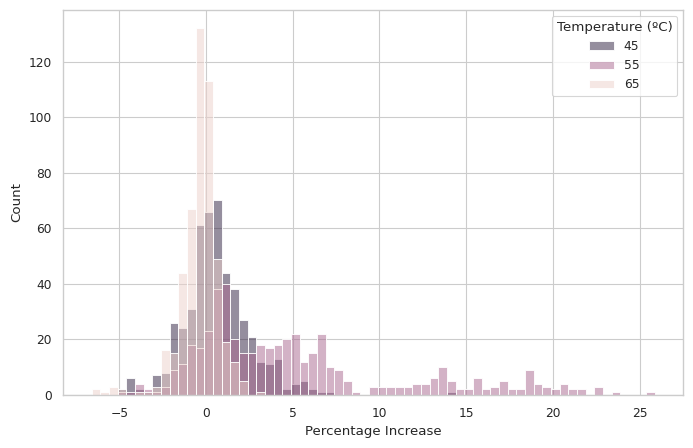

In [14]:
plt.figure(figsize=(8,5))

hist = sns.histplot(hist_df, x='increase', hue='Temperature', binwidth=0.5)
# hist = sns.histplot(hist_df[hist_df['Temperature'].isin([55, 555])], x='increase', hue='Temperature', binwidth=0.5)
plt.xlabel('Percentage Increase')

plt.legend(title='Temperature (ºC)', labels=temperatures)


# plt.savefig(f"../charts/run_diff_hist_{data_col}.pdf", bbox_inches='tight')
plt.show()

In [7]:
data_col = 'execution_time'
temperature = 65

df1 = pd.read_csv(f'../data/results_{temperature}_1.csv')
df2 = pd.read_csv(f'../data/results_{temperature}_2.csv')

df1['total_energy'] = df1['pkg_energy'] + df1['dram_energy']
df2['total_energy'] = df2['pkg_energy'] + df2['dram_energy']

df1['power_dissipation'] = df1['total_energy'] / df1['execution_time']
df2['power_dissipation'] = df2['total_energy'] / df2['execution_time']



progs = df1['program'].unique()
print(f"Programs ({len(progs)}): {progs}")
flags = df1['flag'].unique()
print(f"Flags ({len(flags)}): {flags}")

Programs (18): ['circsim' 'hash' 'bernouilli' 'integrate' 'coins' 'queens' 'anna' 'fluid'
 'fannkuch-redux' 'binary-trees' 'n-body' 'pidigits' 'reverse-complement'
 'spectral-norm' 'callback001' 'chan' 'power' 'treejoin']
Flags (27): ['-O2' '-fno-case-merge' '-fno-case-folding' '-fno-call-arity'
 '-fno-exitification' '-fno-cmm-elim-common-blocks' '-fno-cmm-sink'
 '-fno-block-layout-cfg' '-fno-cpr-anal' '-fno-cse' '-fno-stg-cse'
 '-fno-dmd-tx-dict-sel' '-fno-do-eta-reduction'
 '-fno-do-lambda-eta-expansion' '-fno-float-in' '-fno-full-laziness'
 '-fno-ignore-asserts' '-fno-loopification' '-fno-specialise'
 '-fno-solve-constant-dicts' '-fno-stg-lift-lams' '-fno-strictness'
 '-fno-unbox-small-strict-fields' '-fno-spec-constr' '-fno-liberate-case'
 '-funfolding-use-threshold=40' '-funfolding-use-threshold=160']


In [8]:
increase_df = calculate_increase(df1, df2, data_col)
increase_df['sig'] = [False] * len(increase_df)

sorted_df = increase_df.sort_values('increase')
display(head := sorted_df.head(30))
display(tail := sorted_df.tail(30))

to_test = []
to_test = [*to_test, *[(row['program'], row['flag']) for _, row in head.iterrows()]]
to_test = [*to_test, *[(row['program'], row['flag']) for _, row in tail.iterrows()]]

print(to_test)

,program,flag,base_mean,diff_mean,increase,sig
385,fluid,-fno-strictness,179895.42005,150703.12170,-16.227372,False
150,anna,-fno-cpr-anal,199782.67700,179644.71855,-10.079932,False
272,bernouilli,-fno-full-laziness,127953.42210,115741.19140,-9.544278,False
349,fluid,-fno-solve-constant-dicts,143909.53720,130775.87100,-9.126335,False
168,anna,-fno-cse,196072.31170,178797.12810,-8.810619,False
...,...,...,...,...,...,...
416,bernouilli,-fno-spec-constr,119642.63035,113800.67125,-4.882841,False
56,bernouilli,-fno-call-arity,121013.05235,115199.86095,-4.803772,False
91,hash,-fno-cmm-elim-common-blocks,348567.30695,331896.79685,-4.782580,False
277,fluid,-fno-full-laziness,140258.77660,133772.00540,-4.624859,False


,program,flag,base_mean,diff_mean,increase,sig
118,n-body,-fno-cmm-sink,174576.09075,179844.36015,3.017750,False
393,chan,-fno-strictness,47546.74960,49022.01305,3.102764,False
332,fannkuch-redux,-fno-specialise,303478.23680,312938.62275,3.117319,False
439,fluid,-fno-liberate-case,130790.74870,134984.09460,3.206149,False
136,n-body,-fno-block-layout-cfg,173874.39560,179473.01715,3.219923,False
...,...,...,...,...,...,...
380,bernouilli,-fno-strictness,124195.57285,131987.45085,6.273877,False
403,fluid,-fno-unbox-small-strict-fields,131593.39420,139965.56965,6.362155,False
399,integrate,-fno-unbox-small-strict-fields,105475.96695,112268.45050,6.439840,False
51,chan,-fno-case-folding,44988.06220,47923.36765,6.524632,False


[('fluid', '-fno-strictness'), ('anna', '-fno-cpr-anal'), ('bernouilli', '-fno-full-laziness'), ('fluid', '-fno-solve-constant-dicts'), ('anna', '-fno-cse'), ('anna', '-fno-unbox-small-strict-fields'), ('chan', '-fno-dmd-tx-dict-sel'), ('fluid', '-fno-loopification'), ('fluid', '-fno-call-arity'), ('reverse-complement', '-fno-full-laziness'), ('n-body', '-fno-stg-cse'), ('fluid', '-funfolding-use-threshold=40'), ('n-body', '-fno-cse'), ('spectral-norm', '-fno-spec-constr'), ('power', '-fno-case-folding'), ('chan', '-fno-call-arity'), ('n-body', '-fno-case-folding'), ('fluid', '-fno-cmm-sink'), ('chan', '-funfolding-use-threshold=40'), ('anna', '-fno-loopification'), ('power', '-fno-call-arity'), ('n-body', '-fno-exitification'), ('spectral-norm', '-fno-specialise'), ('n-body', '-fno-ignore-asserts'), ('spectral-norm', '-fno-unbox-small-strict-fields'), ('bernouilli', '-fno-spec-constr'), ('bernouilli', '-fno-call-arity'), ('hash', '-fno-cmm-elim-common-blocks'), ('fluid', '-fno-full-la

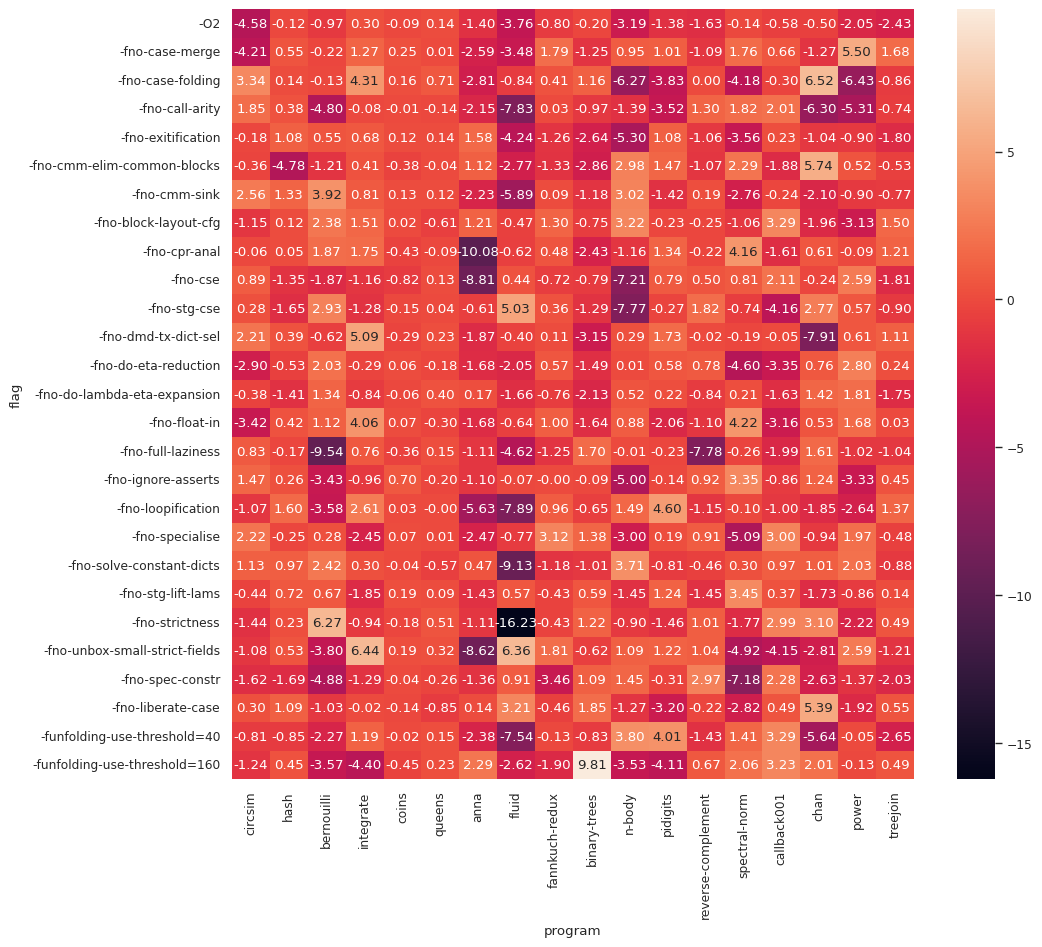

In [9]:
plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = increase_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = increase_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f'
)

# plt.savefig(f"../charts/{data_col}_{temperature}_temperature_heat.pdf", bbox_inches='tight')
plt.show()

In [10]:
from multiprocessing import Pool
from scipy.stats import ttest_ind
from utils import random_sampling, is_normal


# task = [(prog, flag) for prog in progs for flag in flags]
task = to_test
# task = [('reverse-complement', '-fno-call-arity'), ('chan', '-O2')]
# task = [('fluid', '-fno-strictness')]

def is_significant(sample):
    prog, flag = sample
    
    fst_run_df = df1[(df1['flag'] == flag) & (df1['program'] == prog)]
    snd_run_df = df2[(df2['flag'] == flag) & (df2['program'] == prog)]
    
    fst_run_data = fst_run_df[data_col].values
    snd_run_data = snd_run_df[data_col].values
    
    if is_normal(fst_run_data) and is_normal(snd_run_data) and np.var(fst_run_data) != np.var(snd_run_data):
        _, p = ttest_ind(fst_run_data, snd_run_data, equal_var=False)
    else:
        p, _, _ = random_sampling(fst_run_df, snd_run_df, data_col, reps=100000)
        
    return prog, flag, p


with Pool() as pool:
    results = pool.map(is_significant, task)

    for prog, flag, pvalue in results:
        i = increase_df.index[(increase_df['program'] == prog) & (increase_df['flag'] == flag)].values[0]
        increase_df.at[i, 'sig'] = pvalue < 0.05

increase_df[increase_df['sig'] == True]

KeyboardInterrupt: 

In [ ]:
sig_increase_df = increase_df[increase_df['sig'] == True]

display(sig_increase_df[sig_increase_df.increase == sig_increase_df.increase.max()])
display(sig_increase_df[sig_increase_df.increase == sig_increase_df.increase.min()])

,program,flag,base_mean,diff_mean,increase,sig
477,binary-trees,-funfolding-use-threshold=160,255702.23045,280799.03445,9.814855,True


,program,flag,base_mean,diff_mean,increase,sig
385,fluid,-fno-strictness,179895.42005,150703.1217,-16.227372,True
